<a href="https://colab.research.google.com/github/thinkGrow/Neural-Network-CSC424/blob/main/nn_3b_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt     
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import math

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
x_train = trainset.data
x_test = testset.data
y_train = np.array(trainset.targets)
y_test = np.array(testset.targets)
x_train = x_train/255 #50,000*32*32*3
x_test = x_test/255

In [ ]:
#reshape
x_train = x_train.reshape(x_train.shape[0], 3072) #50,000 x 3072
x_test = x_test.reshape(x_test.shape[0], 3072) #10000 x 3072
y_train = y_train.reshape(50000,1)
y_test = y_test.reshape(10000,1)

In [ ]:
def sigmoid(x):
    x = np.clip(x, -80, 100)
    return 1/(1+np.exp(-x))

def sigmoid_der(x):
    return x*(1-x)

def softmax(A):
    A = np.clip(A, -100, 80)
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)

def xavier_initializer(fan_in, fan_out) :
    limit = math.sqrt(6/(fan_in + fan_out))

    fan_in_o = 4000
    fan_out_o = 1
    limit_o = math.sqrt(6/(fan_in_o + fan_out_o))

    return np.random.uniform(-limit, limit, size=(fan_in, fan_out)) 

#function to turn y to one hot encode
def ohe(to_encode):
    ohe = np.zeros((to_encode.shape[0],10))
    for i in range(to_encode.shape[0]):
        for j in range(10):
            if to_encode[i] == j:
                ohe[i][j] = 1 
    return ohe

In [ ]:
y_train_ohe = ohe(y_train)
y_test_ohe = ohe(y_test)

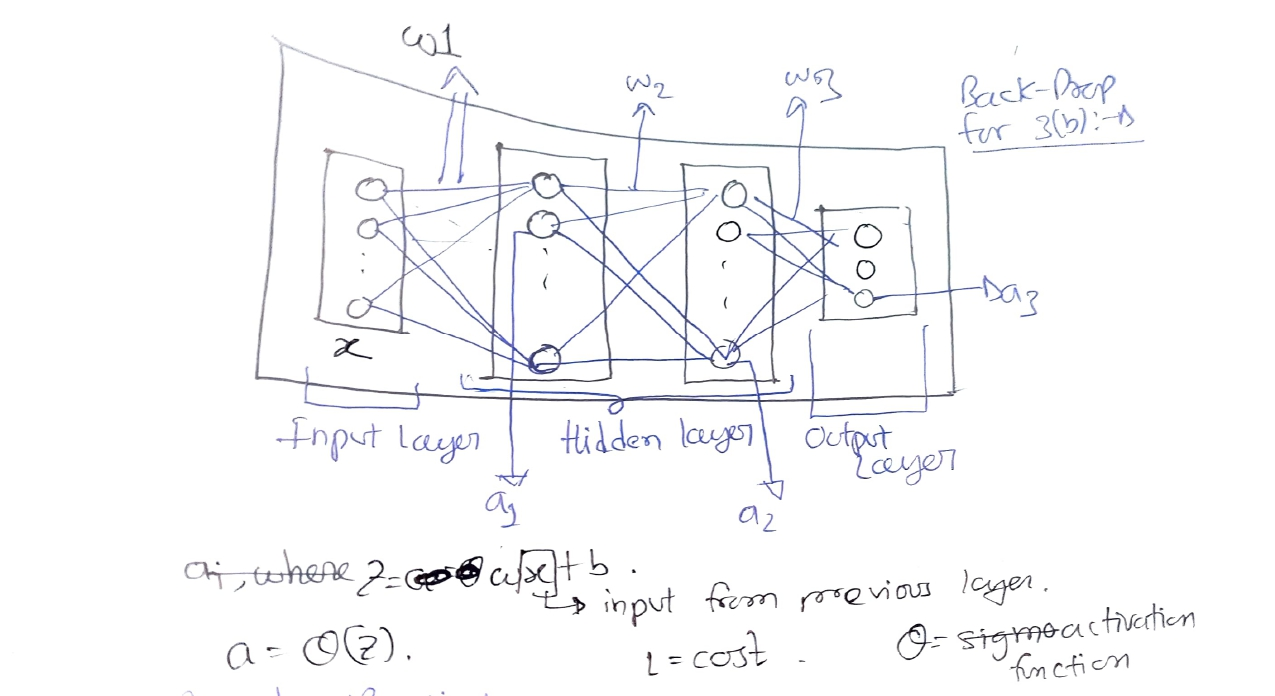

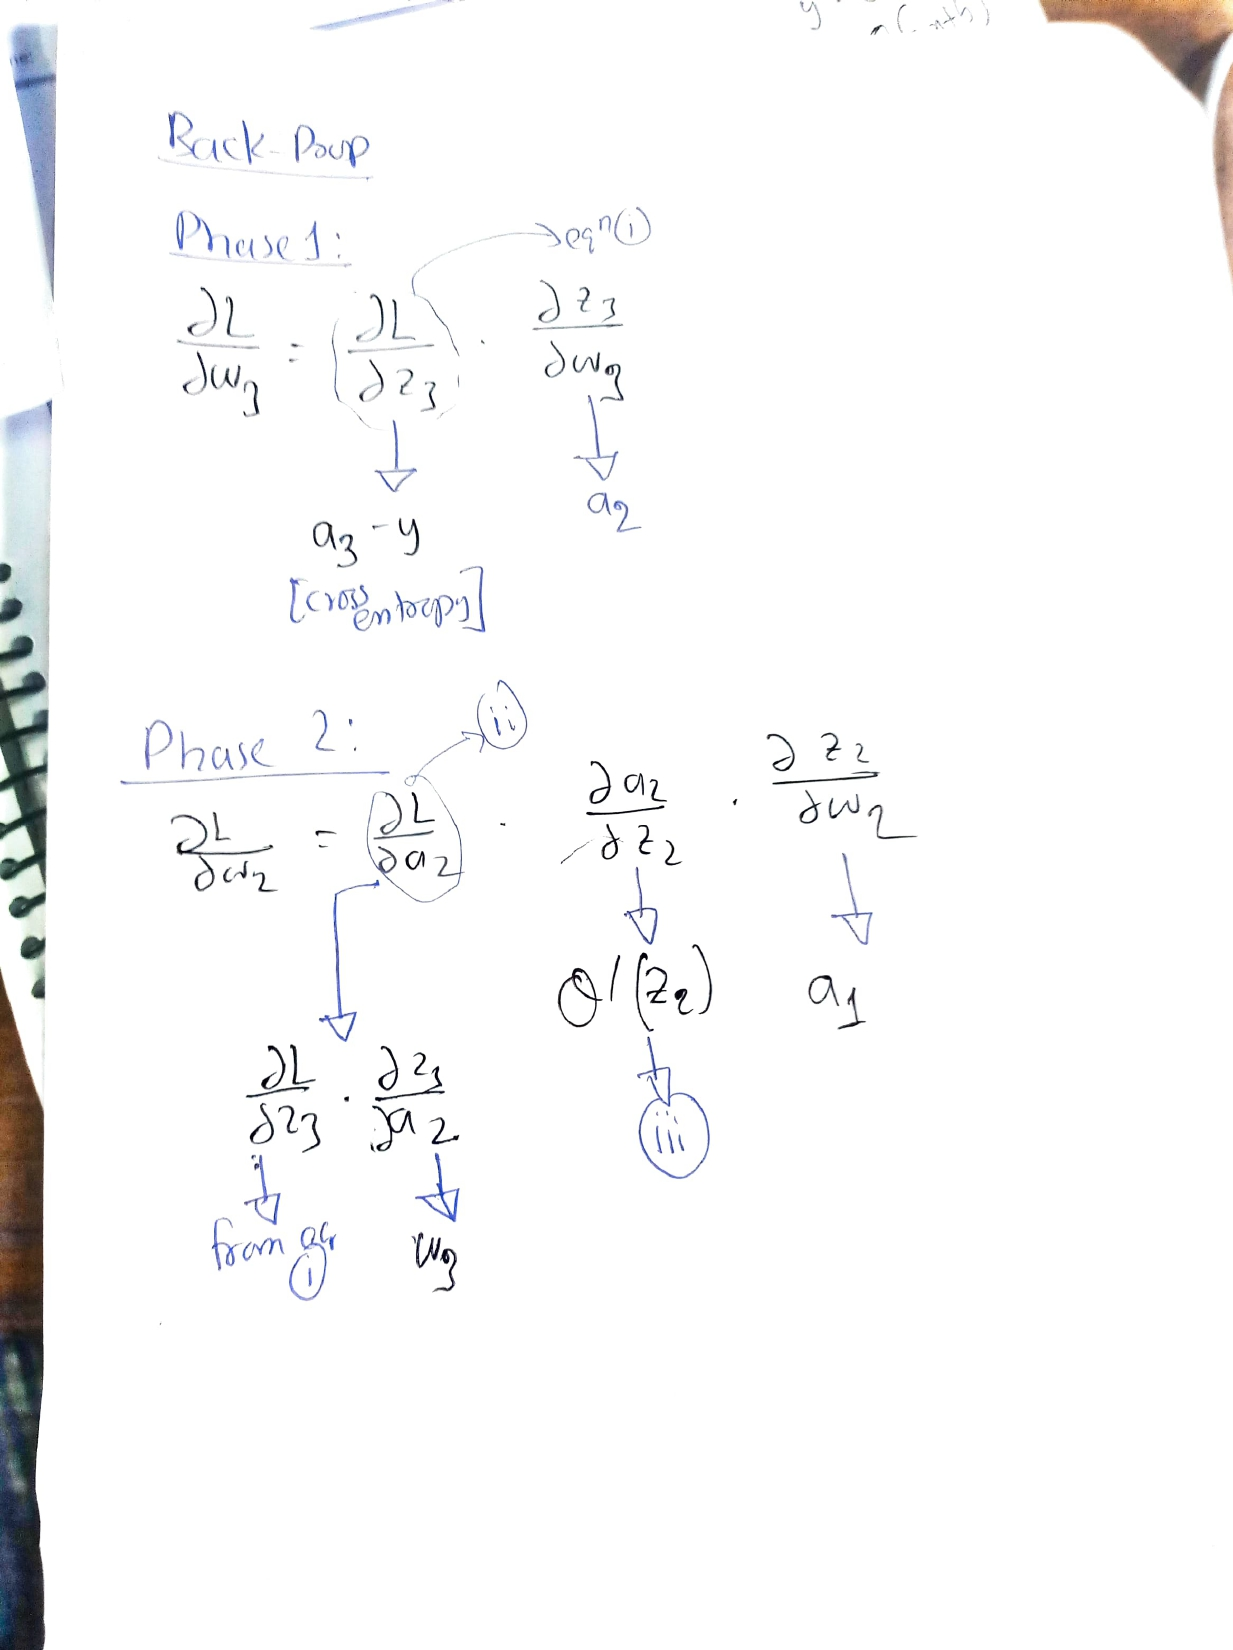

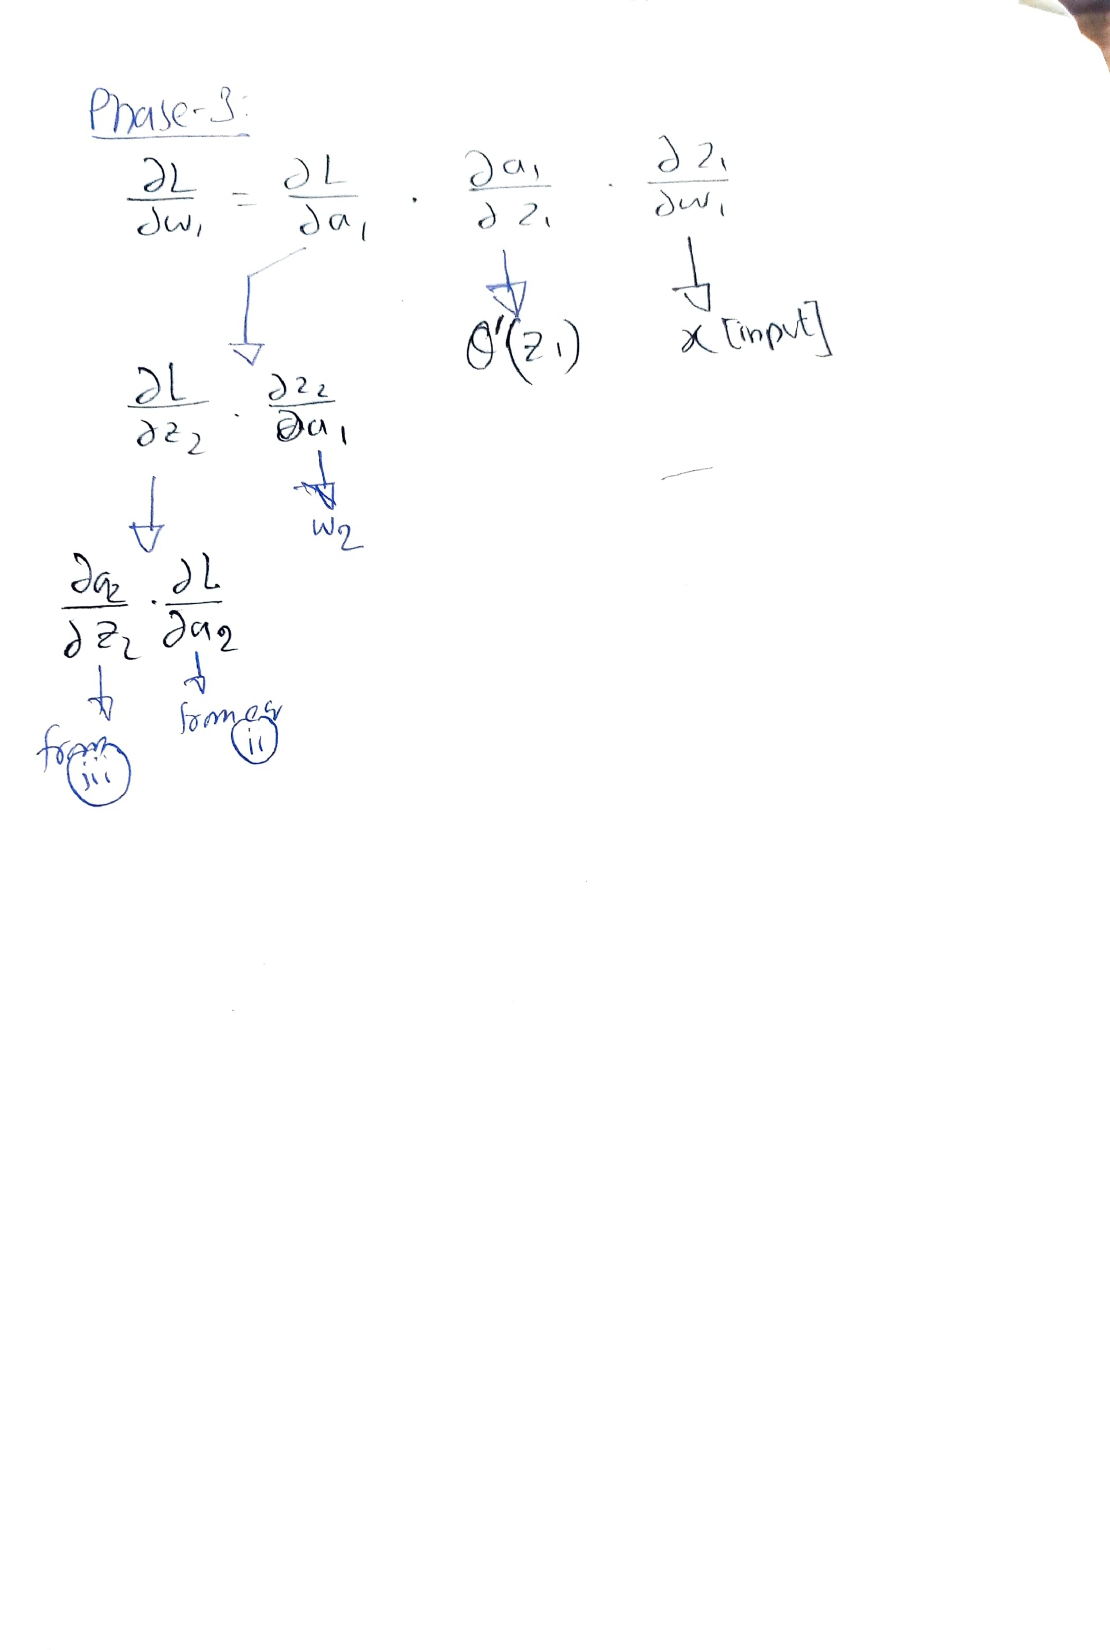

In [ ]:
class NeuralNetwork:
    def __init__(self):
        self.w1 = xavier_initializer(3072,4000)
        # self.w1 = np.random.rand(3072,4000)
        self.b1 = np.random.randn(4000)

        self.w2 = xavier_initializer(4000,4000)
        self.b2 = np.random.randn(4000)

        self.w3 = xavier_initializer(4000,10)
        self.b3 = np.random.randn(10)

        self.lr = 0.001

        self.batch_size = 1000
        
    
    def train(self, x_train, y_train) :
        loss = 0.0
        for epoch in range(10):
            
            error_cost = []
            i = 0
            j = self.batch_size
            loss_epoch_temp = 0

            ## Feed Forward
            for k in range(50000//self.batch_size):
                x_batch = x_train[i:j,:]
                y_batch = y_train[i:j,:]
                i += self.batch_size
                j += self.batch_size

                # Phase 1
                z1 = np.dot(x_batch, self.w1) + self.b1
                a1 = sigmoid(z1)

                # Phase 2
                z2 = np.dot(a1, self.w2) + self.b2
                a2 = sigmoid(z2)

                # Phase 3
                z3 = np.dot(a2, self.w3) + self.b3
                a3 = softmax(z3)

            ## Back Propagation
                
                #Phase 1
                # dL_da3 = y_train/a3
                # da3_dz3 = softmax_der(z3)
                dL_dz3 = a3 - y_batch 
                dz3_dw3 = a2
                dL_w3 = np.dot(dz3_dw3.T, dL_dz3)

                # dL_db3 = dL_da3 * da3_dz3
                dL_db3 = np.sum(dL_dz3, axis=0, keepdims=True)

                #Phase 2

                # dL_da2 = np.dot(dcost_dao , dao_dah.T)
                
                dz2_dw2 = a1

                da2_dz2 = sigmoid_der(a2)

                dz3_da2 = self.w3
                # dL_dz3 = dL_da3 * da3_dz3

                dL_da2 = np.dot(dL_dz3, dz3_da2.T )
                # dL_da2 = dL_dz3 * dz3_da2.T #(1000,10) (4000,10)
                prod = da2_dz2 * dL_da2
                dL_w2 = np.dot(dz2_dw2.T, da2_dz2 * dL_da2)
                
                # dL_dz2 = dL_da2 * da2_dz2
                dL_dz2 = prod
                dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)
                # dL_db2 = dL_da2 * da2_dz2

                #Phase 3
                
                dz1_dw1 = x_batch

                da1_dz1 = sigmoid_der(a1)

                dz2_da1 = self.w2
                

                dL_da1 = np.dot(dL_dz2, dz2_da1.T)
                # dL_da1 = dL_dz2 * dz2_da1   #(1000,4000) (4000,4000) 

                prod_2 = da1_dz1*dL_da1
                # dL_w1 = np.dot(dz1_dw1.T, da1_dz1*dL_da1)
                dL_w1 = np.dot(dz1_dw1.T, prod_2)


                # dL_dz1 = dL_da1 * da1_dz1
                dL_dz1 = prod
                dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)
                #dL_db1 = dL_dz1 * dz1_db1
                #dz1_db1 is a ones matrix


                # Update Weights 

                self.w1 -= self.lr * dL_w1
                self.b1 -= self.lr * dL_db1.sum(axis=0)

                self.w2 -= self.lr * dL_w2
                self.b2 -= self.lr * dL_db2.sum(axis=0)

                self.w3 -= self.lr * dL_w3
                self.b3 -= self.lr * dL_db3.sum(axis=0)

                
                loss = np.sum(-y_batch * np.log(a3))
                loss = loss.item()
                # print('Loss of batch ', i, ': ',  loss)
                loss_epoch_temp += loss
            
            print(f'epoch no. {epoch} : {loss_epoch_temp}') 
            loss_epoch_temp = []


    def test(self, x_test):    
        w1 = self.w1
        w2 = self.w2
        w3 = self.w3
        lr = self.lr
        
        # Phase 1
        z1 = np.dot(x_test, self.w1) + self.b1
        a1 = sigmoid(z1)

        # Phase 2
        z2 = np.dot(a1, self.w2) + self.b2
        a2 = sigmoid(z2)

        # Phase 3
        z3 = np.dot(a2, self.w3) + self.b3
        a3 = softmax(z3)

        return a3

In [ ]:
nn = NeuralNetwork()
nn.train(x_train, y_train_ohe)
y_predict = nn.test(x_test)

epoch no. 0 : 272856.306011116
epoch no. 1 : 114593.7737463585
epoch no. 2 : 114123.77308843828
epoch no. 3 : 112752.95112212001
epoch no. 4 : 110299.30288390366
epoch no. 5 : 107217.79477496076
epoch no. 6 : 104157.79758184259
epoch no. 7 : 102696.97842672844
epoch no. 8 : 101143.45107947968
epoch no. 9 : 99592.8814063486


In [ ]:
#turn y_predict to one hot encode
index = np.argmax(y_predict, axis=1)
y_predict_ohe = np.zeros((10000,10))

for i in range(10000):    
    for j in range(10):
        if j == index[i]:
              y_predict_ohe[i][index[i]]= 1
        else: y_predict_ohe[i][j]=0 

In [ ]:
#Accuracy

import pandas as pd
from sklearn.metrics import accuracy_score
print(f'Accuracy : { accuracy_score(y_test_ohe, y_predict_ohe)}' )

Accuracy : 0.2688
